In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import fully_connected as fc
#from sklearn.manifold import TSNE

from ThemeSeacher import Updator, clean, PhraserModel, tokenizer
from ThemeSeacher import KeywordDict, Model, Extractor
from ThemeSeacher import EmbeddingModel, Clustering

/home/qara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Embedding default loaded


In [2]:
phraser = PhraserModel().get_phraser
dic = KeywordDict(phraser=phraser).get_dict

phraser_default.bin  loaded
keyword dictionary loaded


# Pickle Functions

In [3]:
def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def exist(name):
    return os.path.exists('obj/' + name + '.pkl')


# Embedding

In [4]:
embedding = EmbeddingModel().get_embedding

Embedding default loaded


In [5]:
embedding.wv.most_similar('injure')

/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('injured', 0.8661491870880127),
 ('gunman_open', 0.7204433083534241),
 ('kill_injure', 0.706171989440918),
 ('polouse', 0.6975724697113037),
 ('gunman', 0.6966133117675781),
 ('seriously_injured', 0.6949796676635742),
 ('gun_violence', 0.6782202124595642),
 ('transnational_gang', 0.6755882501602173),
 ('gunman_kill', 0.6751905679702759),
 ('assailant', 0.6713752150535583)]

In [6]:
train_data = load_obj('seq2seq_embed')
len(train_data)

557440

# Generator

In [7]:
def generator(data, bs):
    np.random.shuffle(data)
    for i in range(len(data)//bs):
        batch = data[bs*i: bs*(i+1)]

        x_gen = list(map(lambda k: np.pad(k, \
                ((0,40-len(k)),(0,0)),'constant'), batch))
        mask_gen = list(map(lambda k: np.array(\
                [0 for i in range(40-len(k))] + \
                [1 for j in range(len(k))]), batch))

        yield np.flip(np.array(list(x_gen)),1), np.array(list(mask_gen))

# Model

In [8]:
class mixmodel(object):
    def __init__(self, n_z=4, sigma=1e-3, lr_1=1e-3, lr_2=1e-4, alpha=1, beta=1):
        self.title_len = 40
        self.em_dim = 100
        self.hidden_dim = 100
        
        self.n_z = n_z
        self.beta = beta
        self.sigma = sigma
    
        self.x = tf.placeholder(tf.float32, [None, self.title_len, self.em_dim])
        self.mask = tf.placeholder(tf.float32, [None, self.title_len])
        
        self.x_len = tf.reduce_sum(self.mask, axis=1)
    
        ### Seq2seq Encoder ###
        # seq -> embed
        self.sentence_embed = self.s2s_encoder(self.x)
        
        eps_embed = tf.random_normal(shape=tf.shape(self.sentence_embed),
                            mean=0, stddev=self.sigma, dtype=tf.float32)
        self.noised_embed = self.sentence_embed + eps_embed
        
        # embed -> recon_embed
        self.x_recon = self.s2s_decoder(self.noised_embed)
        #self.x_recon = self.s2s_decoder(self.sentence_embed)
        
        ### VAE Encoder ###
        # embed -> z_mean, z_sigma -> z
        self.z_mu, self.z_log_sigma_sq = self.vae_encoder(self.noised_embed)
        #self.z_mu, self.z_log_sigma_sq = self.vae_encoder(self.sentence_embed)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=self.sigma, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        ### VAE Decoder ###
        # z -> embed_hat
        self.sentence_embed_hat = self.vae_decoder(self.z)

        ### Seq2seq Decoder ###
        # embed_hat -> seq_hat
        self.x_gen = self.s2s_decoder(self.sentence_embed_hat)
        
        t_vars = tf.trainable_variables()
        s2s_vars = [v for v in t_vars if 's2s' in v.name]
        vae_vars = [v for v in t_vars if 'vae' in v.name] + [t for t in t_vars if 's2s_decoder' in t.name]
        
        
        ## Seq2Seq Loss ##
        # Reconstruction loss
        s2s_l2_loss = tf.reduce_mean(tf.squared_difference(self.x, self.x_recon), axis=2)
        
        self.s2s_loss = tf.reduce_mean(tf.reduce_sum(s2s_l2_loss * self.mask, axis=1)/self.x_len)
        #self.s2s_train = tf.train.MomentumOptimizer(lr_1, 0.9, use_nesterov=True).minimize(self.s2s_loss, var_list=s2s_vars)
        self.s2s_train = tf.train.AdamOptimizer(learning_rate=lr_1).minimize(self.s2s_loss, var_list=s2s_vars)
        
        ## VAE Loss ##
        # Embedding L2 loss
        self.embed_loss = tf.reduce_mean(tf.squared_difference(self.sentence_embed, self.sentence_embed_hat))
        
        # Reconstruction loss
        vae_l2_loss = tf.reduce_mean(tf.squared_difference(self.x, self.x_gen), axis=2)
        self.l2_loss = alpha * tf.reduce_mean(tf.reduce_sum(vae_l2_loss * self.mask, axis=1)/self.x_len)
        
        # Latent loss : Kullback Leibler divergence
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = self.beta * tf.reduce_mean(latent_loss)
        
        self.vae_loss = self.embed_loss + self.l2_loss + self.latent_loss
        #self.vae_train = tf.train.MomentumOptimizer(lr_2, 0.9, use_nesterov=True).minimize(self.vae_loss, var_list = vae_vars)
        self.vae_train = tf.train.AdamOptimizer(learning_rate=lr_2).minimize(self.vae_loss, var_list = vae_vars)
    
    def s2s_encoder(self, x):
        encoder_cell = tf.contrib.rnn.LSTMCell(self.hidden_dim)
        encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
            encoder_cell, 
            x,
            dtype=tf.float32, 
            time_major=False,
            scope="s2s_encoder",
        )
        return encoder_final_state[1]
    
    def s2s_decoder(self, sentence_embed):
        with tf.variable_scope('s2s_decoder', reuse=tf.AUTO_REUSE):
            s_code = tf.reshape(sentence_embed, [-1, 1, self.hidden_dim])
            decoder_cell = tf.contrib.rnn.LSTMCell(self.em_dim)
            decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
                decoder_cell, 
                tf.tile(s_code, [1, self.title_len, 1]),
                initial_state = tf.contrib.rnn.LSTMStateTuple(sentence_embed, sentence_embed),
                dtype=tf.float32, 
                time_major=False, 
                #scope="s2s_decoder",
            )
        
        return tf.reverse(decoder_outputs, [1])
    
    def vae_encoder(self, x):
        f1 = fc(x, 128, scope='vae_enc_fc1', activation_fn=tf.nn.elu)
        #f1 = slim.batch_norm(f1, scope='vae_enc_fc1')
        f2 = fc(f1, 128, scope='vae_enc_fc2', activation_fn=tf.nn.elu)
        #f2 = slim.batch_norm(f2, scope='vae_enc_fc2')
        f3 = fc(f2, 128, scope='vae_enc_fc3', activation_fn=tf.nn.elu)
        #f3 = slim.batch_norm(f3, scope='vae_enc_fc3')
        f4 = fc(f3, 64, scope='vae_enc_fc4', activation_fn=tf.nn.elu)
        #f4 = slim.batch_norm(f4, scope='vae_enc_fc4')
        f5 = fc(f4, 64, scope='vae_enc_fc5', activation_fn=tf.nn.elu)
        #f5 = slim.batch_norm(f5, scope='vae_enc_fc5')
        
        z_mu = fc(f5, self.n_z, scope='vae_enc_fc11_mu', activation_fn=None)
        z_log_sigma_sq = fc(f5, self.n_z, scope='vae_enc_fc11_sigma', activation_fn=None)
        
        return z_mu, z_log_sigma_sq
    
    def vae_decoder(self, z):
        g6 = fc(z, 64, scope='vae_dec_fc6', activation_fn=tf.nn.elu)
        #g6 = slim.batch_norm(g6, scope='vae_dec_fc6')
        g7 = fc(g6, 64, scope='vae_dec_fc7', activation_fn=tf.nn.elu)
        #g7 = slim.batch_norm(g7, scope='vae_dec_fc7')
        g8 = fc(g7, 128, scope='vae_dec_fc8', activation_fn=tf.nn.elu)
        #g8 = slim.batch_norm(g8, scope='vae_dec_fc8')
        g9 = fc(g8, 128, scope='vae_dec_fc9', activation_fn=tf.nn.elu)
        #g9 = slim.batch_norm(g9, scope='vae_dec_fc9')
        g10 = fc(g9, 128, scope='vae_dec_fc10', activation_fn=tf.nn.elu)
        #g10 = slim.batch_norm(g10, scope='vae_dec_fc10')
        sentence_embed_hat = fc(g10, 100, scope='vae_dec_fc11', activation_fn=None)
        
        return sentence_embed_hat
    

In [9]:
tf.reset_default_graph()
model = mixmodel(n_z=32, sigma=1e-3, lr_1=1e-3, lr_2=1e-4, alpha=1, beta=1)

tfconfig = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess=tf.Session(config=tfconfig)
sess.run(tf.global_variables_initializer())

### Load Model

In [12]:
model_name = 'seq2seq_20'
#model_name = 'mo_vae_50'
saver = tf.train.Saver()
saver.restore(sess, './ckpt_bn/%s.ckpt' %model_name)

INFO:tensorflow:Restoring parameters from ./ckpt_bn/seq2seq_20.ckpt


### Training Seq2seq

In [11]:
bs=1000
num_steps=len(train_data)//bs
ne=100
print_step=100
save_step=5

saver = tf.train.Saver(max_to_keep=20)

for epoch in range(ne):
    print('Epoch: [%d/%d]' %(epoch+1, ne))
    count = 0
    avg_loss = 0
    
    for batch in generator(train_data, bs):
        loss , _ = sess.run([model.s2s_loss, model.s2s_train], \
                feed_dict={model.x: batch[0], model.mask: batch[1]})
        
        avg_loss += loss
        
        count += 1
        if count%print_step==0:
            print('steps-%d / total loss: %.4f'\
                 %(count, avg_loss/count))
    

    if (epoch+1)%save_step==0:
        saver.save(sess, './ckpt_bn/seq2seq_%d.ckpt'%(epoch+1)) 

Epoch: [1/100]
steps-100 / total loss: 0.0618
steps-200 / total loss: 0.0595
steps-300 / total loss: 0.0579
steps-400 / total loss: 0.0567
steps-500 / total loss: 0.0558
Epoch: [2/100]
steps-100 / total loss: 0.0508
steps-200 / total loss: 0.0505
steps-300 / total loss: 0.0503
steps-400 / total loss: 0.0500
steps-500 / total loss: 0.0498
Epoch: [3/100]
steps-100 / total loss: 0.0485
steps-200 / total loss: 0.0483
steps-300 / total loss: 0.0482
steps-400 / total loss: 0.0481
steps-500 / total loss: 0.0480
Epoch: [4/100]
steps-100 / total loss: 0.0472
steps-200 / total loss: 0.0472
steps-300 / total loss: 0.0471
steps-400 / total loss: 0.0470
steps-500 / total loss: 0.0469
Epoch: [5/100]
steps-100 / total loss: 0.0464
steps-200 / total loss: 0.0463
steps-300 / total loss: 0.0463
steps-400 / total loss: 0.0462
steps-500 / total loss: 0.0462
Epoch: [6/100]
steps-100 / total loss: 0.0457
steps-200 / total loss: 0.0457
steps-300 / total loss: 0.0457
steps-400 / total loss: 0.0456
steps-500 /

KeyboardInterrupt: 

### Training VAE

In [ ]:
bs=1000
num_steps=len(train_data)//bs
ne=100
print_step=100
save_step=5

saver = tf.train.Saver(max_to_keep=20)

for epoch in range(ne):
    print('Epoch: [%d/%d]' %(epoch+1, ne))
    count = 0
    avg_loss = 0
    avg_embed_loss = 0
    avg_l2_loss = 0
    avg_latent_loss = 0
    
    for batch in generator(train_data, bs):
        loss, e_loss, l2_loss, l_loss , _ = sess.run([model.vae_loss, \
                model.embed_loss, model.l2_loss, model.latent_loss, model.vae_train], \
                feed_dict={model.x: batch[0], model.mask: batch[1]})
        
        avg_loss += loss
        avg_embed_loss += e_loss
        avg_l2_loss += l2_loss
        avg_latent_loss += l_loss
        
        count += 1
        if count%print_step==0:
            print('steps-%d\ntotal loss: %.4f, embed: %.4f, l2: %.4f, latent: %.4f'\
                 %(count, avg_loss/count, avg_embed_loss/count, avg_l2_loss/count, avg_latent_loss/count))
    

    if (epoch+1)%save_step==0:
        saver.save(sess, './ckpt_bn/vae_%d.ckpt'%(epoch+1)) 

Epoch: [1/100]
steps-100
total loss: 0.4015, embed: 0.1145, l2: 0.0773, latent: 0.2097
steps-200
total loss: 0.2690, embed: 0.0664, l2: 0.0717, latent: 0.1310
steps-300
total loss: 0.2140, embed: 0.0490, l2: 0.0694, latent: 0.0955
steps-400
total loss: 0.1838, embed: 0.0403, l2: 0.0682, latent: 0.0753
steps-500
total loss: 0.1646, embed: 0.0350, l2: 0.0673, latent: 0.0623
Epoch: [2/100]
steps-100
total loss: 0.0834, embed: 0.0136, l2: 0.0631, latent: 0.0067
steps-200
total loss: 0.0824, embed: 0.0135, l2: 0.0628, latent: 0.0061
steps-300
total loss: 0.0816, embed: 0.0134, l2: 0.0626, latent: 0.0056
steps-400
total loss: 0.0809, embed: 0.0134, l2: 0.0623, latent: 0.0052
steps-500
total loss: 0.0803, embed: 0.0133, l2: 0.0621, latent: 0.0049
Epoch: [3/100]
steps-100
total loss: 0.0767, embed: 0.0129, l2: 0.0607, latent: 0.0031
steps-200
total loss: 0.0764, embed: 0.0129, l2: 0.0605, latent: 0.0030
steps-300
total loss: 0.0760, embed: 0.0128, l2: 0.0604, latent: 0.0029
steps-400
total los

Epoch: [23/100]
steps-100
total loss: 0.0612, embed: 0.0072, l2: 0.0533, latent: 0.0008
steps-200
total loss: 0.0612, embed: 0.0072, l2: 0.0533, latent: 0.0008
steps-300
total loss: 0.0612, embed: 0.0071, l2: 0.0533, latent: 0.0008
steps-400
total loss: 0.0612, embed: 0.0071, l2: 0.0533, latent: 0.0008
steps-500
total loss: 0.0612, embed: 0.0071, l2: 0.0533, latent: 0.0008
Epoch: [24/100]
steps-100
total loss: 0.0610, embed: 0.0071, l2: 0.0531, latent: 0.0008
steps-200
total loss: 0.0610, embed: 0.0071, l2: 0.0531, latent: 0.0008
steps-300
total loss: 0.0610, embed: 0.0071, l2: 0.0531, latent: 0.0008
steps-400
total loss: 0.0610, embed: 0.0071, l2: 0.0532, latent: 0.0008
steps-500
total loss: 0.0610, embed: 0.0071, l2: 0.0532, latent: 0.0008
Epoch: [25/100]
steps-100
total loss: 0.0610, embed: 0.0070, l2: 0.0531, latent: 0.0008
steps-200
total loss: 0.0609, embed: 0.0070, l2: 0.0531, latent: 0.0008
steps-300
total loss: 0.0609, embed: 0.0070, l2: 0.0531, latent: 0.0008
steps-400
total 

steps-500
total loss: 0.0589, embed: 0.0062, l2: 0.0520, latent: 0.0008
Epoch: [45/100]
steps-100
total loss: 0.0588, embed: 0.0061, l2: 0.0520, latent: 0.0007
steps-200
total loss: 0.0588, embed: 0.0061, l2: 0.0520, latent: 0.0007
steps-300
total loss: 0.0588, embed: 0.0061, l2: 0.0520, latent: 0.0007
steps-400
total loss: 0.0588, embed: 0.0061, l2: 0.0519, latent: 0.0007
steps-500
total loss: 0.0588, embed: 0.0061, l2: 0.0519, latent: 0.0007
Epoch: [46/100]
steps-100
total loss: 0.0589, embed: 0.0061, l2: 0.0520, latent: 0.0007
steps-200
total loss: 0.0588, embed: 0.0061, l2: 0.0519, latent: 0.0007
steps-300
total loss: 0.0588, embed: 0.0061, l2: 0.0519, latent: 0.0007
steps-400
total loss: 0.0588, embed: 0.0061, l2: 0.0519, latent: 0.0007
steps-500
total loss: 0.0588, embed: 0.0061, l2: 0.0519, latent: 0.0007
Epoch: [47/100]
steps-100
total loss: 0.0587, embed: 0.0061, l2: 0.0519, latent: 0.0007
steps-200
total loss: 0.0587, embed: 0.0061, l2: 0.0519, latent: 0.0007
steps-300
total 

# Evaluation

In [56]:
def generate_seq2seq(word_list, model):
    title = [x for x in word_list if len(x)!=1]
    embed = embedding[title]
    x = np.pad(np.flip(embed, 0), ((40-len(embed),0), (0,0)), 'constant')
    mask = np.array([0 for i in range(40-len(embed))] + [1 for i in range(len(embed))])
    
    output = sess.run(model.x_recon, feed_dict={model.x: [np.array(list(x))], \
                       model.mask: [np.array(list(mask))]})
    
    return output[0][-len(embed):]

def generate_vae(word_list, model):
    title = [x for x in word_list if len(x)!=1]
    embed = embedding[title]
    x = np.pad(np.flip(embed, 0), ((40-len(embed),0), (0,0)), 'constant')
    mask = np.array([0 for i in range(40-len(embed))] + [1 for i in range(len(embed))])
    
    output = sess.run(model.x_gen, feed_dict={model.x: [np.array(list(x))], \
                       model.mask: [np.array(list(mask))]})
    
    return output[0][-len(embed):]

def sentence_embed(word_list, model):
    title = [x for x in word_list if len(x)!=1]
    embed = embedding[title]
    x = np.pad(np.flip(embed, 0), ((40-len(embed),0), (0,0)), 'constant')
    mask = np.array([0 for i in range(40-len(embed))] + [1 for i in range(len(embed))])
    
    code = sess.run([model.z],\
                       feed_dict={model.x: [np.array(list(x))], \
                       model.mask: [np.array(list(mask))]})
    
    return code

In [77]:
def similar_by_distance(target_vec, num_out=10):
    distance = np.sum(np.power(embedding.wv.vectors - target_vec, 2), axis=1)
    idx = np.argpartition(distance, num_out)
    result = []
    for i in range(num_out):
        result.append(embedding.wv.index2word[idx[i]])
    return result

In [58]:
total_data = load_obj('total_data')

idx = total_data.groupby(['date'])['score'].transform(max) == total_data['score']
top_news = total_data[idx].sort_values(by=['date'])

hot_news = total_data[total_data.score>=1000]
common_news = total_data[total_data.score==0]

top_news = top_news.reset_index(drop=True)
hot_news = hot_news.sort_values(by='date').reset_index(drop=True)
common_news = common_news.sort_values(by='date').reset_index(drop=True)

In [145]:
test_s2s = generate_seq2seq('what barack obama is doing new barack obama latest news today'.split(), model)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
for i in range(len(test_s2s)):
    print(similar_by_distance(test_s2s[-i-1]))
    print()

['anyone', 'simply', 'remember', 'so', 'exactly', 'hope', 'maybe', 'again', 'everyone', 'enough']

['metaphorically_reimagine', 'angry', 'barack_obama', 'reply', 'civil_disobedience', 'arrogantly', 'someone', 'obama', 'embellishment', 'excuse']

['benghazi_consulate', 'brown', 'christian', 'flabbergasted', 'obama', 'recount', 'civil_disobedience', 'require_conspiratorial', 'immigration_lawyer', 'president_obama']

['president_mahmoud', 'che_guevara', 'bashir', 'counterterroism', 'narcoterrorist', 'talleyrand', 'benghazi_consulate', 'benito_mussolini', 'yanukovych', 'kohver']

['personally', 'insist', 'supposition', 'linklater', 'press', 'explain', 'recount', 'drumwright', 'call', 'accidentally']

['also', 'rather', 'similarly', 'appear', 'indeed', 'instance', 'example', 'yet', 'call', 'sort']

['linklater', 'insist', 'indeed', 'instance', 'sort', 'matter', 'course', 'neither', 'explain', 'personally']

['instance', 'linklater', 'neither', 'indeed', 'sort', 'explain', 'insist', 'course'

In [154]:
index = 50
test_s2s = generate_seq2seq(top_news.lemmatized[index], model)
test_vae = generate_vae(top_news.lemmatized[index], model)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [155]:
print(top_news.lemmatized[index])

['photo', 'suspect', 'boston_bomb', 'release']


In [156]:
for i in range(len(test_s2s)):
    print(top_news.lemmatized[index][i])
    print(similar_by_distance(test_s2s[-i-1]))
    print(similar_by_distance(test_vae[-i-1]))
    print()

photo
['occasional_gimme', 'photo', 'photojournalist', 'photorealistic', 'scene', 'message', 'photograph', 'selfie_orchestrated', 'photographic', 'friend']
['linklater', 'instance', 'insist', 'refer', 'indeed', 'camp', 'country', 'invite', 'press', 'rather']

suspect
['fire', 'suspect', 'counterprotest', 'chaotic_confrontational', 'accidentally', 'scene', 'kill', 'attack', 'instance', 'supposedly']
['insist', 'rather', 'indeed', 'instead', 'instance', 'call', 'course', 'neither', 'meant', 'matter']

boston_bomb
['attack', 'islamic_state', 'enemy', 'terrorist', 'narcoterrorist', 'terrorist_plot', 'combat_terrorism', 'diplomatic_mission', 'destroy_islamic', 'decapitation_campaign']
['indeed', 'rather', 'instance', 'insist', 'matter', 'course', 'instead', 'call', 'meant', 'neither']

release
['call', 'also', 'appear', 'meanwhile', 'instance', 'yet', 'soon', 'fact', 'similarly', 'part']
['course', 'insist', 'rather', 'instead', 'instance', 'indeed', 'call', 'also', 'similarly', 'meant']



In [157]:
for i in range(len(test_s2s)):
    print(top_news.lemmatized[index][i])
    similar_s2s = embedding.similar_by_vector(test_s2s[-i-1])
    words, similarities = zip(*similar_s2s)
    #similarities = list(map(lambda k: float('%.2f'%k), similarities))
    #similar_s2s = zip(words, similarities)
    print(words)
    
    similar_vae = embedding.similar_by_vector(test_vae[-i-1])
    words, similarities = zip(*similar_vae)
    #similarities = list(map(lambda k: float('%.2f'%k), similarities))
    #similar_vae = zip(words, similarities)
    print(words)
    #print(list(similar_s2s))
    #print(list(similar_vae))
    print()

photo
('photo', 'photograph', 'occasional_gimme', 'snapchat_gonna', 'blanket_photography', 'photo_video', 'selfie_orchestrated', 'photojournalist', 'text', 'pig_polouse')
('destroy_islamic', 'restore_diplomatic', 'iranian', 'libyan_dictator', 'islamic_state', 'annex_crimea', 'crimean', 'communist', 'moscow', 'islamic_relation')

suspect
('attack', 'polouse', 'benghazi_attack', 'kill', 'intimidation_violence', 'suspect', 'assailant', 'policeman', 'benghazi_terrorist', 'shooting')
('insist', 'protest', 'invite', 'innocent_bystander', 'refuse', 'complain', 'confrontation_swedish', 'president_obama', 'resolve_diplomatically', 'extradite')

boston_bomb
('islamic_state', 'muslim_terrorist', 'combat_terrorism', 'syrian', 'islamic_terrorist', 'dirty_bomb', 'taliban_terrorist', 'terrorist', 'syrium', 'enemy')
('insist', 'protest', 'innocent_bystander', 'complain', 'refuse', 'invite', 'confrontation_swedish', 'kill', 'extradite', 'restore_diplomatic')

release
('release', 'also', 'follow', 'conf

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  if __name__ == '__main__':


In [360]:
index = 1
test_s2s = generate_seq2seq(total_data.lemmatized[index], model)
test_vae = generate_vae(total_data.lemmatized[index], model)
print(sentence_embed(total_data.lemmatized[index], model)[0][0])

[ 0.00644613 -0.00499399 -0.00549687  0.00621958]


/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [361]:
print(total_data.lemmatized[index])

['president', 'obama', 'want', 'give', 'young', 'leader', 'world', 'tool', 'organize']


In [362]:
for i in range(len(test_s2s)):
    print(total_data.lemmatized[index][i])
    similar_s2s = embedding.similar_by_vector(test_s2s[-i])
    words, similarities = zip(*similar_s2s)
    similarities = list(map(lambda k: float('%.2f'%k), similarities))
    similar_s2s = zip(words, similarities)
    
    similar_vae = embedding.similar_by_vector(test_vae[-i])
    words, similarities = zip(*similar_vae)
    similarities = list(map(lambda k: float('%.2f'%k), similarities))
    similar_vae = zip(words, similarities)
    print(list(similar_s2s))
    print(list(similar_vae))
    print()

president
[('friend', 0.79), ('compassionate', 0.78), ('loudmouth', 0.78), ('knowledge_morality', 0.77), ('lifelong_friendship', 0.77), ('imagine', 0.77), ('self_righteously', 0.76), ('cuban', 0.76), ('organizer', 0.76), ('society', 0.76)]
[('protest', 0.76), ('insist', 0.75), ('restore_diplomatic', 0.74), ('innocent_bystander', 0.74), ('confrontation_swedish', 0.74), ('invite', 0.74), ('resolve_diplomatically', 0.73), ('declare_sanctuary', 0.73), ('confrontational', 0.73), ('diplomatically', 0.73)]

obama
[('president', 0.89), ('appoint', 0.78), ('secretary_steven', 0.77), ('oust_secretary', 0.77), ('appointment', 0.77), ('nominee_secretary', 0.76), ('former', 0.76), ('stephen_harper', 0.75), ('outgoing', 0.75), ('david_plouffe', 0.75)]
[('destroy_islamic', 0.79), ('restore_diplomatic', 0.78), ('crimean', 0.77), ('iranian', 0.77), ('libyan_dictator', 0.77), ('annex_crimea', 0.77), ('islamic_state', 0.77), ('communist', 0.77), ('moscow', 0.76), ('islamic_relation', 0.76)]

want
[('obam

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  


# Distribution

In [163]:
def generate_from_df(df):
    x = []
    mask = []
    for idx, row in df.iterrows():
        title = list(row.lemmatized)
        title = [x for x in title if len(x)!=1]
        if len(title)>40:
            title = title[:40]

        k = embedding[title]
        x.append(np.pad(k, ((40-len(k),0), (0,0)), 'constant'))
        mask.append(np.array([0 for i in range(40-len(k))] + [1 for i in range(len(k))]))
        
    yield np.array(list(x)), np.array(list(mask))

def extract_code(df, bs=0):
    codes = []
    c=0
    if bs==0:
        bs = len(df)
    if len(df)==0:
        return
    for i in range((len(df))//bs):
    #for i in range((len(df)+bs-1)//bs):
        small_df = df[bs*i:bs*(i+1)]
        for x, mask in generate_from_df(small_df):
            c += 1
            code = sess.run(model.z_mu, feed_dict={
                model.x: x, model.mask: mask
            })
            codes.append(code)

            if c*bs%1000==0:
                print(c*bs)
    codes = np.array(list(codes))
    codes = np.reshape(codes, [-1, 4])
    return codes

def show_embeds(codes, size=10):
    colors = cm.rainbow(np.linspace(1, 0, len(codes)))
    fig, ax = plt.subplots(1, model.n_z - 1, figsize=(size,size/(model.n_z-1)))
    x1 = codes[:, 0]
    for idx in range(1, model.n_z):
        y1 = codes[:, idx]
        #ax[idx-1].set_xlim(-0.15, 0.15)
        #ax[idx-1].set_ylim(-0.15, 0.15)
        ax[idx-1].scatter(x1, y1, color=colors, s=5)

    plt.show()

def show_embeds_16dim(codes):
    colors = cm.rainbow(np.linspace(1, 0, len(codes)))
    fig, ax = plt.subplots(2, 8, figsize=(20, 5))
    x1 = codes[:, 0]
    #for idx in range(1, model.n_z):
    for idx1 in range(2):
        for idx2 in range(8):
            y1 = codes[:, 8*idx1+idx2]
            #ax[idx-1].set_xlim(-0.15, 0.15)
            #ax[idx-1].set_ylim(-0.15, 0.15)
            ax[idx1, idx2].scatter(x1, y1, color=colors, s=5)

    plt.show()

### Average Log Embedding

In [164]:
total_data = load_obj('upper1')

In [166]:
startt = time.time()
c = 0
average_codes = []
for date in pd.date_range('2013-01-01', '2018-06-01'):
    c += 1
    if c%200 == 0:
        print(day_code)
        print(c, 'steps -', time.time()-startt, 'sec')
    
    df_day = total_data[total_data.date.apply(str) == date.strftime('%Y-%m-%d')].reset_index(drop=True)
    if len(df_day)==0:
        #print(date)
        continue
    
    upcount = 0
    day_code = np.zeros(4, dtype=np.float32)
    codes = extract_code(df_day)
    '''
    #print('codes', type(codes))
    upscores = np.log(list(df_day.score)).reshape(-1,1).transpose()
    #print('upcores', type(upscores))
    
    day_code = np.matmul(upscores, codes)
    upcount = np.sum(upscores)
    '''
    for index in range(len(df_day)):
        upscore = np.log(df_day.score[index])
        upcount += upscore
        day_code += upscore * codes[index]
    
    day_code /= upcount
    average_codes.append(day_code)
    #new_df.loc[ni, 'embed'] = sentence_embedding
    #new_df.loc[ni, 'embed_log'] = sentence_embedding
    #new_df.loc[ni, 'embed_exp'] = sentence_embedding

print('Done.')

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


[ 1.2289833e-03 -3.2353133e-04  1.9905572e-04 -5.0263367e-05]
200 steps - 70.54005765914917 sec
[-0.00458322  0.00045943  0.00195886 -0.00013635]
400 steps - 141.53138494491577 sec
[ 0.00111475  0.00171963 -0.00033582  0.00084122]
600 steps - 223.30561518669128 sec
[-0.00633432 -0.00140282  0.00110558 -0.00063115]
800 steps - 305.66893887519836 sec
[0.00220254 0.00088199 0.00168196 0.00019525]
1000 steps - 387.0474991798401 sec
[-0.00334423 -0.00090388  0.00148348 -0.0006812 ]
1200 steps - 469.82986068725586 sec
[-0.00157381  0.0015017   0.00250974  0.00083914]
1400 steps - 551.2831184864044 sec
[-0.00073226  0.00082077  0.00083034  0.00030177]
1600 steps - 634.3431446552277 sec
[ 5.3310557e-04 -2.5548699e-04 -4.4875965e-06 -1.7400108e-04]
1800 steps - 719.3506219387054 sec
Done.


In [176]:
save_obj(np.array(average_codes), 'average_log_embed')

In [ ]:
averge_codes = load_obj('average_log_embed')

In [328]:
def generate_from_code(code, model):
    x = np.zeros([1, model.title_len, model.em_dim])
    mask = np.array(list([0 for i in range(30)] + [1 for i in range(10)])).reshape(-1, model.title_len)
    code = code.reshape(-1, model.n_z)
    
    output = sess.run(model.x_gen, feed_dict={model.x: x, \
                       model.mask: mask, model.z: code})
    
    return output[0][-10:]

In [306]:
hot_codes[0]

array([-0.00646924,  0.03985013,  0.05740086,  0.03835747], dtype=float32)

In [295]:
hot_codes[10]

array([ 0.06230161,  0.01042025, -0.04815732, -0.01004691], dtype=float32)

In [329]:
generate_from_code(np.array([-0.00840938, 0.00553992, 0.00267184, 0.01583727]), model)

array([[-1.44554958e-01,  8.87485296e-02, -1.27343446e-01,
         1.65069222e-01, -2.24579230e-01, -1.46412358e-01,
        -2.08976001e-01, -1.28251150e-01, -3.17426205e-01,
         2.36830954e-02,  4.10963781e-02, -7.24505857e-02,
        -1.51132734e-03, -1.88330393e-02, -1.38214260e-01,
         1.38406083e-01,  1.33973673e-01, -8.64819810e-02,
         2.64900234e-02,  1.73891962e-01, -1.84410840e-01,
        -5.04286140e-02, -1.00423573e-02, -2.10199598e-02,
         1.63194031e-01,  2.02331487e-02, -7.95443058e-02,
         1.61604509e-02, -1.98781006e-02,  3.03133130e-02,
        -4.86013889e-02, -2.08014712e-01, -2.27308031e-02,
         2.25717574e-02,  1.83183495e-02, -9.61506963e-02,
        -4.83220294e-02,  9.94877592e-02,  2.89219350e-01,
        -1.94958642e-01, -2.55193233e-01,  1.44150093e-01,
         3.19212765e-01, -8.72161612e-02, -2.69431680e-01,
        -1.53310269e-01,  3.79921645e-02,  1.33392200e-01,
        -2.40052547e-02, -9.05800518e-03,  3.73329930e-0

In [304]:
generate_from_code(hot_codes[0], model)

array([[-1.44554958e-01,  8.87484774e-02, -1.27343416e-01,
         1.65069371e-01, -2.24579304e-01, -1.46412104e-01,
        -2.08975941e-01, -1.28251016e-01, -3.17426145e-01,
         2.36830376e-02,  4.10963073e-02, -7.24506676e-02,
        -1.51134515e-03, -1.88330505e-02, -1.38213888e-01,
         1.38405994e-01,  1.33973703e-01, -8.64820182e-02,
         2.64901053e-02,  1.73891768e-01, -1.84410706e-01,
        -5.04284799e-02, -1.00424690e-02, -2.10195407e-02,
         1.63194135e-01,  2.02330574e-02, -7.95441642e-02,
         1.61604229e-02, -1.98781826e-02,  3.03133894e-02,
        -4.86014225e-02, -2.08014473e-01, -2.27308907e-02,
         2.25716345e-02,  1.83179807e-02, -9.61506665e-02,
        -4.83220443e-02,  9.94878709e-02,  2.89219201e-01,
        -1.94958523e-01, -2.55193144e-01,  1.44150078e-01,
         3.19212675e-01, -8.72163028e-02, -2.69431353e-01,
        -1.53310344e-01,  3.79918814e-02,  1.33392036e-01,
        -2.40051020e-02, -9.05815791e-03,  3.73328254e-0

In [331]:
idx = 121
day_embed = generate_from_code(np.array([-0.00840938, 0.00553992, 0.00267184, 0.01583727]), model)
#day_embed = generate_seq2seq(average_codes[idx], model)
for i in range(len(day_embed)):
    similar = embedding.similar_by_vector(day_embed[-i])
    words, similarities = zip(*similar)
    similarities = list(map(lambda k: float('%.2f'%k), similarities))
    similar = zip(words, similarities)
    
    print(list(similar))
    print()

[('protest', 0.76), ('insist', 0.75), ('innocent_bystander', 0.74), ('restore_diplomatic', 0.74), ('invite', 0.74), ('confrontation_swedish', 0.73), ('resolve_diplomatically', 0.73), ('confrontational', 0.73), ('declare_sanctuary', 0.73), ('complain', 0.73)]

[('destroy_islamic', 0.79), ('restore_diplomatic', 0.78), ('crimean', 0.77), ('iranian', 0.77), ('libyan_dictator', 0.77), ('annex_crimea', 0.77), ('islamic_state', 0.77), ('communist', 0.77), ('moscow', 0.76), ('islamic_relation', 0.76)]

[('protest', 0.77), ('insist', 0.77), ('confrontation_swedish', 0.76), ('innocent_bystander', 0.76), ('invite', 0.75), ('restore_diplomatic', 0.74), ('refuse', 0.74), ('declare_sanctuary', 0.74), ('complain', 0.74), ('resolve_diplomatically', 0.74)]

[('protest', 0.77), ('insist', 0.76), ('innocent_bystander', 0.76), ('confrontation_swedish', 0.75), ('invite', 0.74), ('complain', 0.74), ('kill', 0.74), ('refuse', 0.74), ('declare_sanctuary', 0.74), ('restore_diplomatic', 0.74)]

[('protest', 0.7

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


IndexError: index 4 is out of bounds for axis 1 with size 4

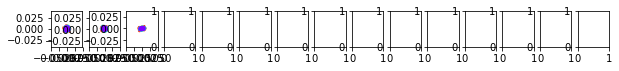

In [368]:
show_embeds(np.array(average_codes).reshape(-1,4))
print('\t\t\t\t  Average Log')

In [168]:
top_codes = extract_code(top_news,10)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


1000


In [169]:
hot_codes = extract_code(hot_news, 100)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [170]:
common_codes = extract_code(common_news, 10000)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000


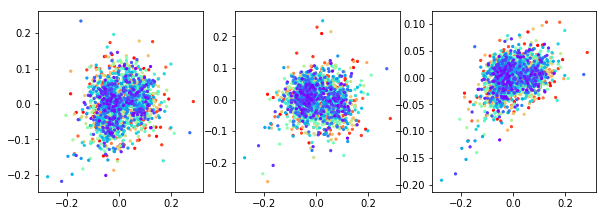

				   Top News


In [171]:
show_embeds(top_codes)
print('\t\t\t\t   Top News')

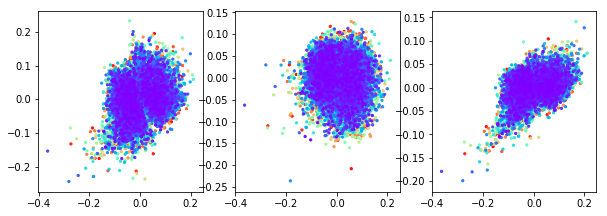

			      Hot News: ups>1000


In [172]:
show_embeds(hot_codes)
print('\t\t\t      Hot News: ups>1000')

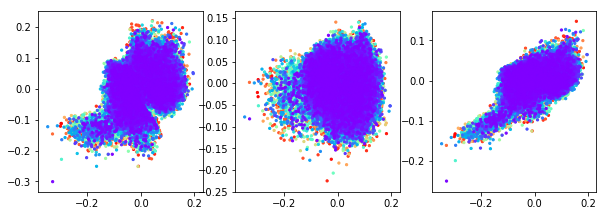

			      Common News: ups==0


In [173]:
show_embeds(common_codes)
print('\t\t\t      Common News: ups==0')